# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1

Annisa Fitri Nurfirdausi

Silje Eriksen - silje.eriksen@studio.unibo.it

Ivan



## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

The system needs to be able to detect both single and multiple instances of objects in on scene objects

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

Load the data:

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
   creating: dataset/scenes/
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: dataset/scenes/scene7.png  
  inflating: __MACOSX/dataset/scenes/._scene7.png  
  inflating: 

## Filtering

The scene images contain some noise. We therfore start by denoising the scene iamges before further processing.

As the first two scene images are less noisy than the rest, we have decided to filter more for the three last images than for the two first.



In [ ]:
import cv2
import numpy as np
imgs_train = ['dataset/scenes/scene{}.png'.format(i) for i in range(1, 6)]
for i in range (len(imgs_train)):
  img = cv2.imread(imgs_train[i])
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  if i < 2:
    img_rgb = cv2.bilateralFilter(img_rgb, 15, 200, 100)

  else:
    # Apply Median Blur to remove salt-and-pepper noise
    median_blur = cv2.medianBlur(img_rgb, 5)

    # Apply Gaussian Blur to smooth the image
    gaussian_blur = cv2.GaussianBlur(median_blur, (5, 5), 0)

    # Apply Bilateral Filter to preserve edges while reducing noise
    img_rgb = cv2.bilateralFilter(gaussian_blur, 9, 75, 75)

    #Edge detection
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    img_rgb = cv2.filter2D(img_rgb, -1, kernel)
    #Sharpening
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    img_rgb = cv2.filter2D(img_rgb, -1, kernel)

  name = imgs_train[i].replace(".png", "_filtered.png")
  cv2.imwrite(name, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
  print(f"save succeded as: {name}")

save succeded as: dataset/scenes/scene1_filtered.png
save succeded as: dataset/scenes/scene2_filtered.png
save succeded as: dataset/scenes/scene3_filtered.png
save succeded as: dataset/scenes/scene4_filtered.png
save succeded as: dataset/scenes/scene5_filtered.png


# Object detection with local Invariant features

We will implement object detection with local invariant features utilizing the Python framework cv2.

This wil be done in four steps:
1. Detection by finding keypoints in model an scene images.
2. Description: create description for each point.
3. Matching: match point in scene and query image based on descriptor
4. Position estimation: estimate poition of query image in scene image.

We therfore create a function *object retrive mult* and *object retrive*, which finds keypoints (step 1), descirbes them (step 2) and matches them (step 3).

##Choice of SIFT

We have decided to utilize SIFT (Scale-Invariant Feature Transform) due to its robustness to scale, rotation, and illumination changes. The choice of SIFT is also the reason for using 0.7 as the threshold when filtering out bad matches, as this was outlined in the paper introducing SIFT.

## Matcher selecter

Furthermore, we have utilized a FLANN-based matcher (Fast Library for Approximate Nearest Neighbors) for efficient nearest neighbor search, ensuring fast and reliable keypoint matching.

## Function diferences

*object_retrieve*: This function is used for matching with a single instance of a given query image. It performs keypoint detection, descriptor computation, and matching for one given query image.

*object_retrieve_mult*: This function is used when there are multiple instances of the same query image. In this function, the keypoints in the scene image are clustered, assuming that keypoints close in distance belong to the same object. Steps 2 and 3 are then run for each cluster. Clustering is done using a MeanShift filter.

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Define a function for object detection pipeline
def object_retrieve(img_query, img_train_denoized, min_match_count):

    # Keypoint detection
    sift = cv2.xfeatures2d.SIFT_create()
    kp_query =  sift.detect(img_query)
    kp_train =  sift.detect(img_train_denoized)

    # Keypoint description
    kp_query, des_query =  sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train_denoized, kp_train)

    # Define parameters for the approximate nearest neighbor algorithm
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    # Initialize the Flann-based matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_query,des_train,k=2)
    good = []

    # Filtering false matches using Lowe's ratio test (0.7 because SIFT)
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)> min_match_count:
      return (kp_train, good), kp_query
    else:
      return None, kp_query

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

# Define a function for object detection pipeline
def object_retrieve_mult(img_query, img_train_denoized, min_match_count):
    # Keypoint detection using SIFT
    sift = cv2.xfeatures2d.SIFT_create(contrastThreshold=0.04)
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train_denoized)

    # Keypoint description
    kp_query, des_query = sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train_denoized, kp_train)

    # Create array from keypoints for clustering
    x = np.array([kp.pt for kp in kp_train])  # Extract coordinates of keypoints

    # Estimate bandwidth for MeanShift clustering
    bandwidth = estimate_bandwidth(x, quantile=0.1, n_samples=500)

    # Perform MeanShift clustering
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
    ms.fit(x)  # Fit MeanShift model to the keypoint coordinates
    labels = ms.labels_  # Get cluster labels for each keypoint
    cluster_centers = ms.cluster_centers_  # Get coordinates of cluster centers

    # Determine the number of unique clusters
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    # Sort clusters by their center coordinates for consistency
    sorted_indices = np.argsort(cluster_centers[:, 0])
    sorted_labels = np.array([np.where(sorted_indices == i)[0][0] for i in labels])
    sorted_cluster_centers = cluster_centers[sorted_indices]

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Initialize FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    objects = []

    # Process each cluster
    for i in range(n_clusters_):
        cluster_indices = np.where(sorted_labels == i)[0]
        cluster_des_train = des_train[cluster_indices, :]
        matches = flann.knnMatch(des_query, cluster_des_train, k=2)

        good = []
        # Filtering false matches using Lowe's ratio test (0.7 because SIFT)
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)

        # If enough good matches are found, add to objects list
        if len(good) > min_match_count:
            objects.append((i, good))

    # Visualize matches
    matches = []
    for cluster_id, good_matches in objects:
        cluster_indices = np.where(sorted_labels == cluster_id)[0]
        kp_cluster = [kp_train[idx] for idx in cluster_indices]
        matches.append((kp_cluster, good_matches))

    return matches, kp_query, kp_train


## Position Estimation Using RANSAC
To accurately locate the query image within the scene image and obtain a good bounding box, even when some keypoint matches are incorrect, we use the RANSAC (Random Sample Consensus) algorithm. RANSAC is an iterative method for robustly fitting a parametric model to a dataset that contains outliers (noisy data). In the context of computer vision, RANSAC is often used to find the homography matrix that transforms points from the query image to the scene image.

In [4]:
def poistion_estimation(good,kp_query, img_query, img_train_denoized):
  instances = []
  src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good[1] ]).reshape(-1,1,2)
  dst_pts =  np.float32([ good[0][m.trainIdx].pt for m in good[1] ]).reshape(-1,1,2)

  # Find Homography matrix using RANSAC
  M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

  # Mask of discarded point used in visualization
  matchesMask = mask.ravel().tolist()
  # Get the bounding box corners of the query image
  h,w = img_query.shape
  pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

  # Project the query corners onto the train image using the homography matrix
  train_corners = cv2.perspectiveTransform(pts,M)

  # Draw the bounding box
  img_train_with_box = cv2.polylines(img_train, [np.int32(train_corners)], True, (0, 255, 0), 3, cv2.LINE_AA)

  bounding_box_height = abs(train_corners[0][0][1] - train_corners[2][0][1])
  bounding_box_width = abs(train_corners[0][0][0] - train_corners[2][0][0])
  center_position = ((train_corners[0][0][0] + train_corners[2][0][0]) / 2, (train_corners[0][0][1] + train_corners[2][0][1]) / 2)

  return img_train_with_box, bounding_box_height, bounding_box_width, center_position

# Single instance

We iterate over all scene images and models which contain solely single instances, and call the function *object_retrieve* to get matches, and *position_estimation* for estimating bounding boxes. The bounding boxes are only computed if enough matches are found, and a count of instances together with the bounding box information is stored for later visualization.

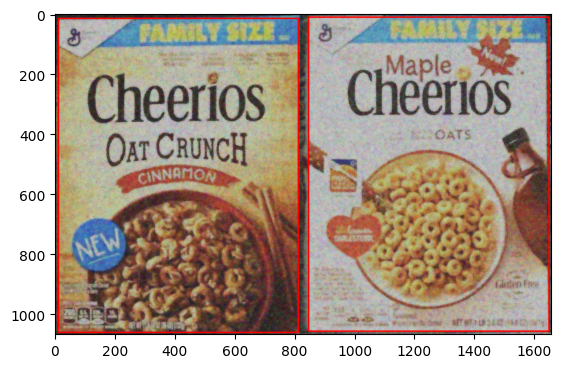

Object 1: {position: (411.9361877441406, 538.7971801757812), width: 802px, height: 1048px
Object 2: {position: (1248.24853515625, 534.3016967773438), width: 803px, height: 1048px


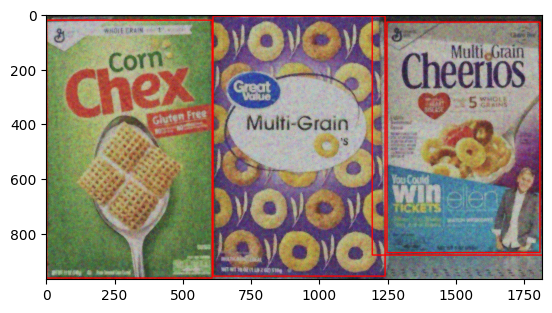

Object 2: {position: (1532.9144287109375, 438.0436096191406), width: 677px, height: 886px
Object 3: {position: (305.4559631347656, 493.4769287109375), width: 605px, height: 942px
Object 4: {position: (926.64013671875, 482.8466796875), width: 630px, height: 950px
Object 5: {position: (1528.38037109375, 450.50244140625), width: 561px, height: 843px


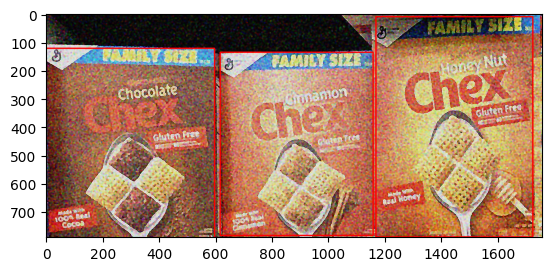

Object 6: {position: (298.1005554199219, 457.08697509765625), width: 600px, height: 670px
Object 7: {position: (888.77490234375, 460.11749267578125), width: 542px, height: 649px
Object 8: {position: (1447.249267578125, 399.4851989746094), width: 556px, height: 779px


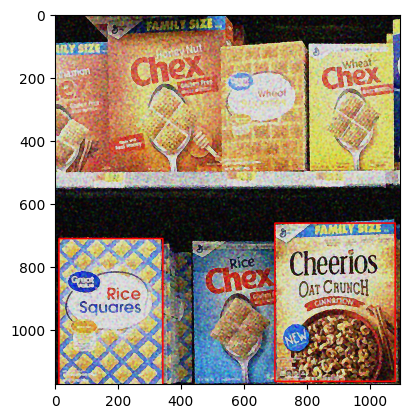

Object 1: {position: (887.012451171875, 914.4885864257812), width: 381px, height: 501px
Object 9: {position: (177.4031982421875, 947.3363647460938), width: 329px, height: 469px


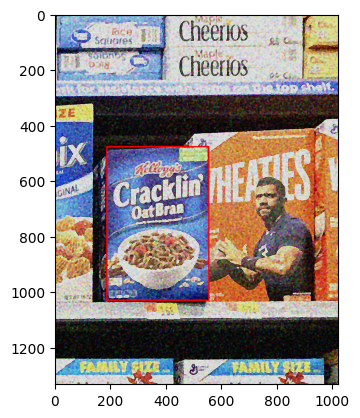

Object 11: {position: (369.88470458984375, 753.77783203125), width: 367px, height: 553px


In [ ]:
contain_img = {}
# Iterate among scenes
imgs_train_filterd = ['dataset/scenes/scene{}_filtered.png'.format(i) for i in range(1, 6)]
for scene_image in imgs_train_filterd:
  # Count instances of each object
  object_counts = {}
  # Initialize variables to store accumulated bounding box information
  all_bounding_boxes = []
  all_center_positions = []
  img_train = cv2.imread(scene_image,0)
  img = cv2.imread(scene_image)

  #Iterate among queryimage to see if in scene
  for i in range(1, 15):
      img_query = cv2.imread('dataset/models/ref{}.png'.format(i),0)

      good, kp_query = object_retrieve(img_query, img_train, 70)

      if good != None:
        # Get bounding boxes, and append to variables to accumulated bounding box information
        img_train_with_box, bounding_box_height, bounding_box_width, center_position = poistion_estimation(good, kp_query, img_query, img_train)
        all_bounding_boxes.append((bounding_box_height, bounding_box_width,i))
        all_center_positions.append(center_position)

        # Count instances of each object
        object_counts.setdefault(len(all_bounding_boxes), 0)
        object_counts[len(all_bounding_boxes)] += 1
  # Draw all bounding boxes on a single image
  if img_train_with_box is not None:
      img_with_boxes = img.copy()
      for i, ((bounding_box_height, bounding_box_width, number), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
          cv2.rectangle(img_with_boxes, (int(center_position[0] - bounding_box_width / 2),
                                           int(center_position[1] - bounding_box_height / 2)),
                          (int(center_position[0] + bounding_box_width / 2),
                           int(center_position[1] + bounding_box_height / 2)), (0, 0, 255), 3)
      plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
      plt.show()

      # Print location information for each instance
      for k, ((bounding_box_height, bounding_box_width, number), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
        print(f'Product {number} instance found: {{position: {center_position}, width: {round(bounding_box_width)}px, height: {round(bounding_box_height)}px')



## Discussion

In our evaluation of instance-based matching across different scene images, we observed varying levels of success in detecting model instances. This variation highlights both the strengths and limitations of our approach, which utilizes object detection with local invariant features using SIFT (Scale-Invariant Feature Transform).

#### Successful Detection in Initial Scenes

For the first three scene images, we achieved a high detection rate, successfully identifying all model instances. This success demonstrates the robustness and effectiveness of using local invariant features for object detection. The key points identified in these images were sufficient and distinctive enough to match correctly against our model instances. At the same time we saw wrong detection of two objects with similar logo, showing that the models has a hard time distingushing between similar objects.


#### Challenges in Noisy and Occluded Scenes

However, our method faced challenges in the last two scene images:

1. **Scene 4 - Noisy Image**:
   The presence of noise in the image made it difficult to correctly match key points.
   Noise can disrupt the detection and description of key points. SIFT involves calculating image gradients, which are highly sensitive to noise. When noise is present, the gradients can be significantly altered, leading to inaccurate key point detection and poor matching performance.

2. **Scene 5 - Partially Occluded Product**:
  The product that was not detected is partially occluded, complicating the recognition process.
  Occlusion presents a significant challenge for instance-based matching because parts of the object are hidden, leading to incomplete key point detection. The detected key points may not provide enough distinctive features to match against the model instances.

#### Positive Outcomes Despite Limitations

Even though not all model instances were detected in the last two scenes, it is important to note that the instances which were detected were correctly identified. This indicates that our method is capable of extracting and matching valuable key points, even in challenging conditions. The correctly detected instances confirm that our approach can still provide useful information, contributing to overall scene understanding.

### Conclusion

The instance-based matching approach utilizing local invariant features has proven effective in various scenarios, particularly when images are clear and unobstructed. However, its performance diminishes in the presence of noise and occlusion. Addressing these limitations through noise reduction techniques, robust key point detectors, and advanced recognition algorithms will be key to improving detection rates in more challenging conditions. Despite these challenges, the accuracy of detected instances in difficult scenes demonstrates the potential and reliability of our method.

# Detection of multiple instances

## Filtering

As stated before, the scene images contain some noise. We therfore start by denoising the scene iamges before further processing.

As the first two scene images (6 and 7) are less noisy than the rest, we have decided to filter more for the three last images than for the two first.

In [5]:
import cv2
imgs_train = ['dataset/scenes/scene{}.png'.format(i) for i in range(6, 13)]
for i in range(len(imgs_train)):
  img = cv2.imread(imgs_train[i])
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if i < 2:
    img_rgb = cv2.bilateralFilter(img_rgb, 15, 200, 100)
  else:
    median_blur = cv2.medianBlur(img_rgb, 5)

    # Apply Gaussian Blur to smooth the image
    gaussian_blur = cv2.GaussianBlur(median_blur, (5, 5), 0)

    # Apply Bilateral Filter to preserve edges while reducing noise
    img_rgb= cv2.bilateralFilter(gaussian_blur, 9, 75, 75)

    # Convert to grayscale
    gray_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # Apply Laplacian filter for edge detection and sharpening
    laplacian = cv2.Laplacian(img_rgb, cv2.CV_64F)
    sharp_edges = cv2.convertScaleAbs(laplacian)

    # Combine the original color image with the sharp edges
    img_rgb = cv2.addWeighted(img_rgb, 0.8, sharp_edges, 0.2, 0)

  name = imgs_train[i].replace(".png", "_filtered.png")
  cv2.imwrite(name, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))

  print(f"save succeded as: {name}")

save succeded as: dataset/scenes/scene6_filtered.png
save succeded as: dataset/scenes/scene7_filtered.png
save succeded as: dataset/scenes/scene8_filtered.png
save succeded as: dataset/scenes/scene9_filtered.png
save succeded as: dataset/scenes/scene10_filtered.png
save succeded as: dataset/scenes/scene11_filtered.png
save succeded as: dataset/scenes/scene12_filtered.png


We iterate over all scene images and models which contain multiple instances, and call the function *object_retrieve_mult* to get matches, and *position_estimation* for estimating bounding boxes. The bounding boxes are only computed if enough matches are found, and a count of instances together with the bounding box information is stored for later visualization.

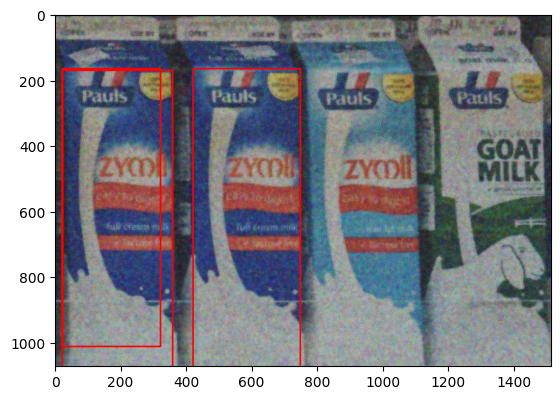

Product 15 - 3 instances found
Instance 1: {position: (172.36526489257812, 589.1911010742188), width: 298px, height: 846px
Instance 2: {position: (190.1057586669922, 626.138916015625), width: 336px, height: 909px
Instance 3: {position: (583.9845581054688, 622.37939453125), width: 326px, height: 911px


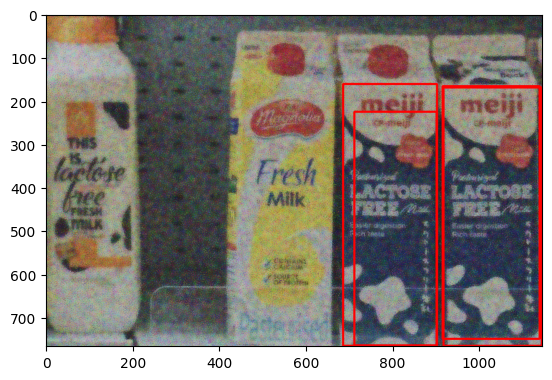

Product 16 - 4 instances found
Instance 1: {position: (795.2933349609375, 463.37078857421875), width: 217px, height: 604px
Instance 2: {position: (807.6007080078125, 495.283935546875), width: 189px, height: 539px
Instance 3: {position: (1031.813720703125, 467.51373291015625), width: 227px, height: 596px
Instance 4: {position: (1028.330322265625, 457.55255126953125), width: 224px, height: 583px


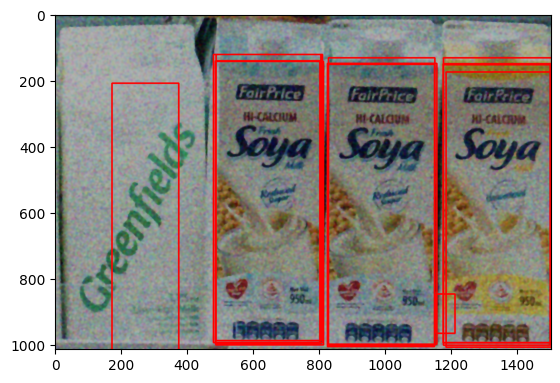

Product 17 - 4 instances found
Instance 1: {position: (649.7706909179688, 572.346923828125), width: 326px, height: 858px
Instance 2: {position: (644.5028686523438, 558.500244140625), width: 330px, height: 872px
Instance 3: {position: (989.76904296875, 574.475830078125), width: 331px, height: 849px
Instance 4: {position: (1340.744384765625, 573.3179321289062), width: 332px, height: 845px
Product 23 - 4 instances found
Instance 1: {position: (645.9931030273438, 555.8521728515625), width: 317px, height: 866px
Instance 2: {position: (988.5897216796875, 568.0941162109375), width: 323px, height: 870px
Instance 3: {position: (1182.57666015625, 907.1868896484375), width: 56px, height: 119px
Instance 4: {position: (1339.4429931640625, 563.6931762695312), width: 328px, height: 862px
Product 24 - 4 instances found
Instance 1: {position: (643.3984375, 569.6064453125), width: 316px, height: 856px
Instance 2: {position: (986.27685546875, 579.3780517578125), width: 324px, height: 855px
Instance 3: {p

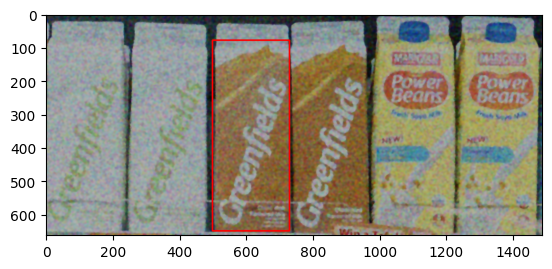

Product 19 - 1 instances found
Instance 1: {position: (615.02734375, 364.14398193359375), width: 231px, height: 571px


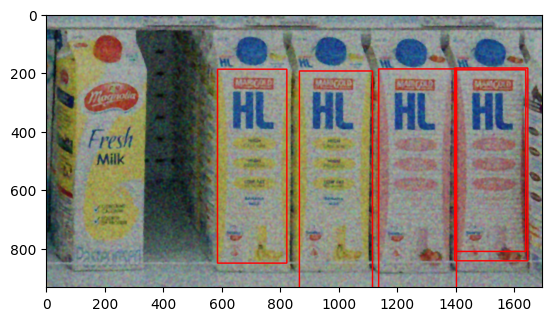

Product 21 - 3 instances found
Instance 1: {position: (704.8035888671875, 519.6001586914062), width: 237px, height: 661px
Instance 2: {position: (991.753173828125, 568.61376953125), width: 250px, height: 749px
Instance 3: {position: (1521.2086181640625, 500.4703674316406), width: 239px, height: 620px
Product 22 - 2 instances found
Instance 1: {position: (1270.716064453125, 563.5191040039062), width: 266px, height: 753px
Instance 2: {position: (1522.59130859375, 513.2977905273438), width: 250px, height: 658px


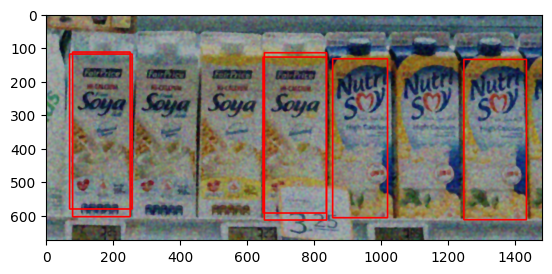

Product 17 - 1 instances found
Instance 1: {position: (163.77511596679688, 350.69720458984375), width: 187px, height: 462px
Product 23 - 2 instances found
Instance 1: {position: (165.28465270996094, 358.5380554199219), width: 173px, height: 491px
Instance 2: {position: (745.5101318359375, 365.4862976074219), width: 186px, height: 499px
Product 24 - 1 instances found
Instance 1: {position: (742.90380859375, 361.3481140136719), width: 188px, height: 465px
Product 25 - 2 instances found
Instance 1: {position: (938.4876098632812, 370.482177734375), width: 165px, height: 474px
Instance 2: {position: (1341.843505859375, 374.5831298828125), width: 187px, height: 478px


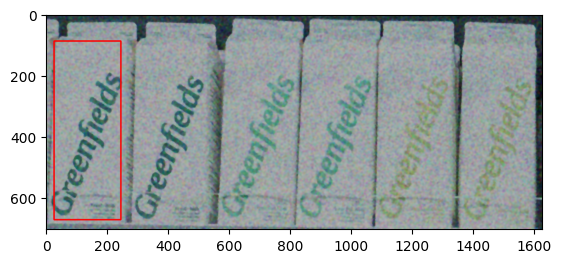

Product 26 - 1 instances found
Instance 1: {position: (135.93409729003906, 380.9027099609375), width: 218px, height: 584px


In [6]:
contain_img = {}
# Iterate among scenes
imgs_train_filterd = ['dataset/scenes/scene{}_filtered.png'.format(i) for i in range(6, 13)]
for scene_image in imgs_train_filterd:
  # Count instances of each object
  object_counts = {}
  # Initialize variables to store accumulated bounding box information
  all_bounding_boxes = []
  all_center_positions = []
  img_train = cv2.imread(scene_image,0)
  img = cv2.imread(scene_image)
  #Iterate among queryimage to see if in scene
  for i in range(15, 27):
      img_query = cv2.imread('dataset/models/ref{}.png'.format(i),0)

      found, kp_query, kp_train = object_retrieve_mult(img_query, img_train, 23)

      if found != []:
        for element in found:
          # Get bounding boxes, and append to variables to accumulated bounding box information
          img_train_with_box, bounding_box_height, bounding_box_width, center_position = poistion_estimation(element, kp_query, img_query, img_train)
          all_bounding_boxes.append((bounding_box_height, bounding_box_width,i))
          all_center_positions.append(center_position)

          img_with_boxes = img.copy()

          # Count instances of each object
          object_id = i
          if object_id in object_counts:
              object_counts[object_id] += 1
          else:
            object_counts[object_id] = 1

  # Draw all bounding boxes on a single image
  if img_train_with_box is not None:
      img_with_boxes = img.copy()

      for i, ((bounding_box_height, bounding_box_width, number), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
          cv2.rectangle(img_with_boxes, (int(center_position[0] - bounding_box_width / 2),
                                           int(center_position[1] - bounding_box_height / 2)),
                          (int(center_position[0] + bounding_box_width / 2),
                           int(center_position[1] + bounding_box_height / 2)), (0, 0, 255), 3)
      plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
      plt.show()

      # Create parameters to keep track of printing
      last_number = 0
      instance_count=0
      # Print location information for each instance
      for k, ((bounding_box_height, bounding_box_width, number), center_position) in enumerate(zip(all_bounding_boxes, all_center_positions), 1):
        if number != last_number:
          print(f'Product {number} - {object_counts[number]} instances found')
          last_number = number
          instance_count = 1
        else:
          instance_count +=1
        print(f'Instance {instance_count}: {{position: {center_position}, width: {round(bounding_box_width)}px, height: {round(bounding_box_height)}px')


## Discussion
The same pattern observed in single instance detection is also evident during detection of multiple instance. The approach is able to find more instances in the first scene images than in the last one. The probable reason for this is that the last scene images contain smaller products, and more noise.
Additionally, we notice significantly worse results when detecting multiple instances then compared with single instances.

1. **Scene 6 and 7**: The approach locates the same instance multiple times. This can be caused by multiple clusters forming over the same instance in the scene.
Some model instances are not detected, indicating that the approach struggles to extract reliable keypoints and descriptors in certain areas of the image.

2. **Scene 8**: All model instances are located, but similar to Scene 1, all of them are detected multiple times. For the specific model instance "Soya", this can be caused by the fact that there are multiple identical products, with the only differentiating feature being color. The color is not taken into account when processing the image, as it is converted to grayscale.
The same is the case for the product to the further left. This duplication can be caused by multiple clusters being present above the picture, as the product is larger than the rest.

3. **Scene 9, 10 and 11**: Many model instances are not found. This can be due to the fact that more products can be observes in these scene images, causing there to be some products without clusters. Furthermore the same issue with colors can be observed in these scenes.

### Conclusion

Even though the results of multiple instance detection are not very good, it is evident that we still can detect valuable keypoints. The instances detected are correct, looking away from color issues, and the bounding boxes found are approximately in the correct position. Multiple instance detection is generally a hard problem, so it is reasonable to see worse results in such a task than with single instance detection.

In general better results could be found by having less noisy images, in other words better filtering. Additionally it is possible that other instance matching methods can work better, like for example template matching.